# Multivariate Time Series Forecasting

# **Group No :151**
## **Group Member Names:**

Peyala Samarasimha Reddy - 2023AA05072 100% Contribution

Monisha G - 2023AA05536 100% Contribution

Akshay Mohan - 2023AA05315 100% Contribution

Sreelakshmi Ajith - 2023AA05316 100% Contribution

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Air Pollution Forecasting

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

Attribute Information:

 - No    : row number
 - year  : year of data in this row
 - month : month of data in this row
 - day   : day of data in this row
 - hour  : hour of data in this row
 - pm2.5 : PM2.5 concentration (ug/m^3)
 - DEWP  : Dew Point
 - TEMP  : Temperature
 - PRES  : Pressure (hPa)
 - cbwd  : Combined wind direction
 - Iws   : Cumulated wind speed (m/s)
 - Is    : Cumulated hours of snow
 - Ir    : Cumulated hours of rain

 Ref: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

## Dataset preparation

In [ ]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('/content/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']],
                      index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

<ipython-input-6-1d06b0b18dda>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = pd.read_csv('/content/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']],


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


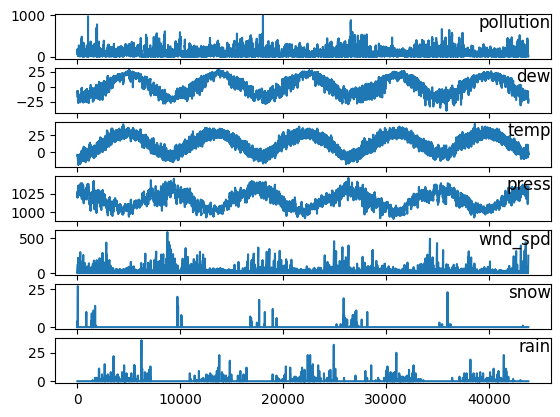

In [ ]:
# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [ ]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Now you have X and y, slice them into training and test dataset.

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
Xtrain, Ytrain = train[:, :-1], train[:, -1]
Xtest, Ytest = test[:, :-1], test[:, -1]

### RNN needs 3D input
# reshape input to be 3D [samples, timesteps, features]
Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## GRU RNN

In [ ]:
gruModel = keras.models.Sequential()

gruModel.add(keras.layers.GRU(50, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))

gruModel.add(keras.layers.Dense(1))

gruModel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           9,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,051 (35.36 KB)

 Trainable params: 9,051 (35.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize.
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing.

gruModel.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [ ]:
# train the model

history = gruModel.fit(Xtrain, Ytrain, epochs = 50, batch_size=72, validation_split=0.1, verbose=1 )

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0673 - mae: 0.0673 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - mae: 0.0138 - val_loss: 0.0140 - val_mae: 0.0140
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0135 - val_mae: 0.0135
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - mae: 0.0141 - val_loss: 0.0138 - val_mae: 0.0138
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

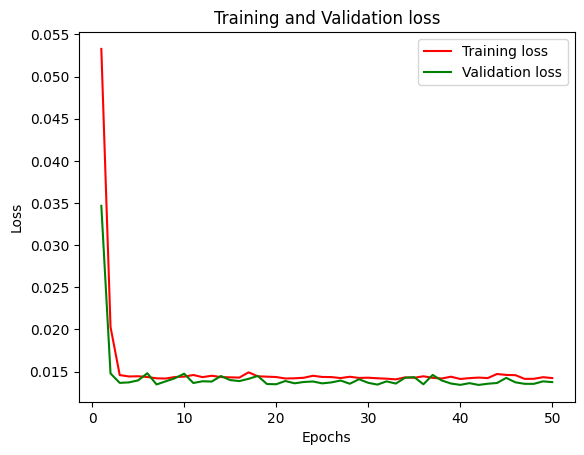

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
testResult = gruModel.evaluate(Xtest, Ytest)
print(testResult)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0133 - mae: 0.0133
[0.013196340762078762, 0.013196340762078762]


# **MODIFICATIONS**

## **Use a different optimizer**

In [ ]:
#Adam replaced by SGD

from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with the new optimizer
gruModel.compile(optimizer=optimizer, loss='mean_squared_error')

## **Train for more epochs**

In [ ]:
history_sgd = gruModel.fit(Xtrain, Ytrain, epochs=100, batch_size=32, validation_data=(Xtest, Ytest))


#history = gruModel.fit(Xtrain, Ytrain, epochs = 50, batch_size=72, validation_split=0.1, verbose=1 )

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 6.9517e-04
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.6349e-04 - val_loss: 7.2113e-04
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.5443e-04 - val_loss: 6.9262e-04
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.0003e-04 - val_loss: 7.0707e-04
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 8.9015e-04 - val_loss: 7.0194e-04
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.8543e-04 - val_loss: 7.0220e-04
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.7222e-04 - val_loss: 6.9437e-04
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0010 - val_loss: 6.9741e-04
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.3077e-04 - val_loss: 6.9484e-04
Epoch 10/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0010 - val_loss: 6.9842e-04
Epoch 11/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - los

## **Graph plot after modification**

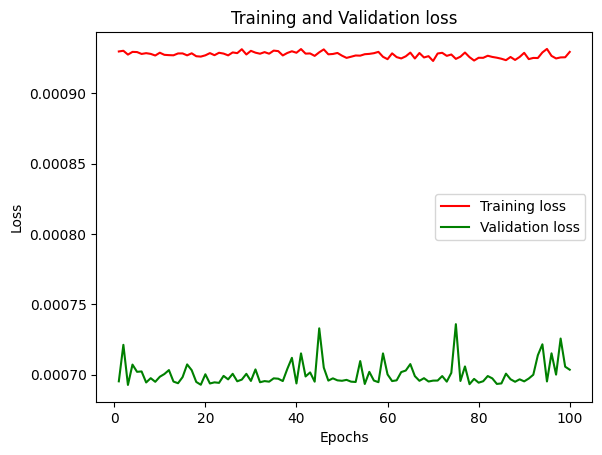

In [ ]:
# plotting training and validation loss

loss = history_sgd.history['loss']
val_loss = history_sgd.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
testResult = gruModel.evaluate(Xtest, Ytest)
print(testResult)

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.1078e-04
0.000703437312040478
